In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

sns.set_style('whitegrid')

## EDA

In [3]:
df = pd.read_csv('Data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
grouped = df.groupby('Rating')['Rating'].count()
grouped

Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: Rating, dtype: int64

<AxesSubplot:xlabel='Rating'>

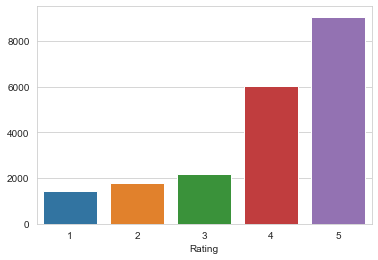

In [5]:
sns.barplot(x = grouped.index, y = grouped.values)

In [6]:
df['words'] = [x.split() for x in df['Review']]

df['word_count'] = [len(x) for x in df['words']]

In [7]:
df.head()

,Review,Rating,words,word_count
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...",87
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...",250
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, 4*, experience, hotel, mona...",217
3,"unique, great stay, wonderful time hotel monac...",5,"[unique,, great, stay,, wonderful, time, hotel...",89
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay,, went, seahawk, gam...",191


In [8]:
grouped_rating = df.groupby('Rating')['word_count'].mean()
grouped_rating

Rating
1    112.365236
2    126.601227
3    114.705586
4    107.771651
5     93.963773
Name: word_count, dtype: float64

<AxesSubplot:xlabel='Rating'>

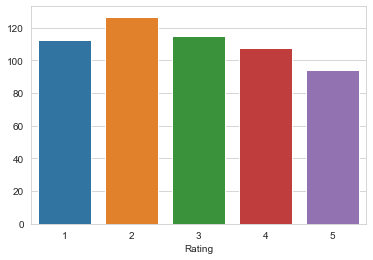

In [9]:
sns.barplot(x = grouped_rating.index, y = grouped_rating.values)

## Preprocessing

In [10]:
sw = stopwords.words('english')

In [11]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [12]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the review corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
#     print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [13]:
df['tokenized'] = df['Review'].apply(doc_preparer)

In [14]:
df.head()

,Review,Rating,words,word_count,tokenized
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...",87,nice hotel expensive parking get good deal sta...
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...",250,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, 4*, experience, hotel, mona...",217,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,"[unique,, great, stay,, wonderful, time, hotel...",89,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay,, went, seahawk, gam...",191,great stay great stay go seahawk game awesome ...


In [16]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


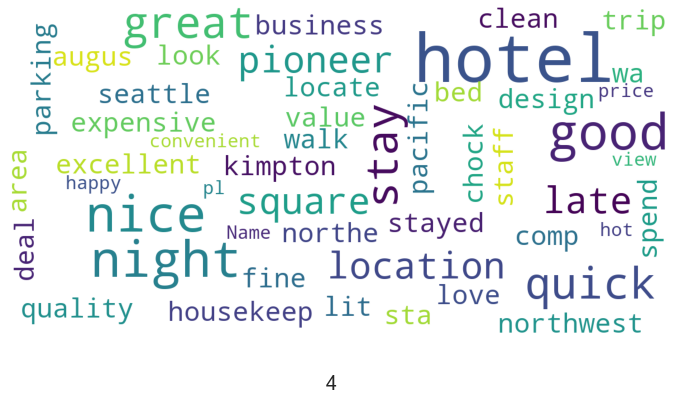

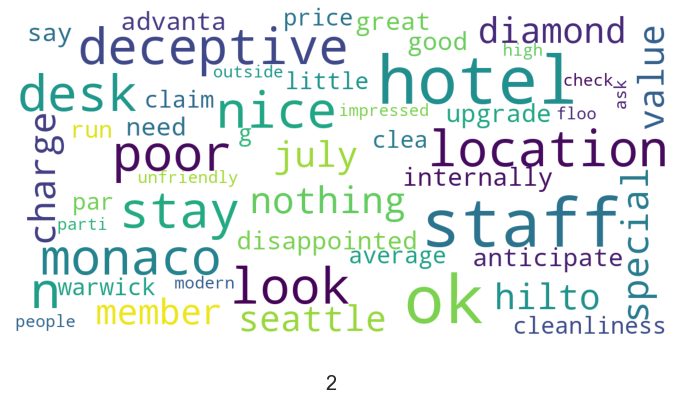

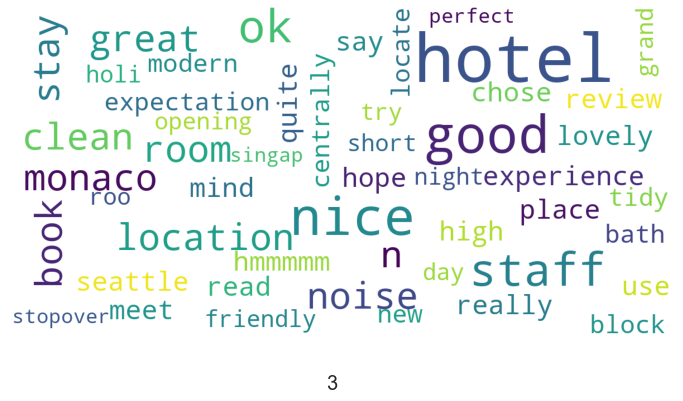

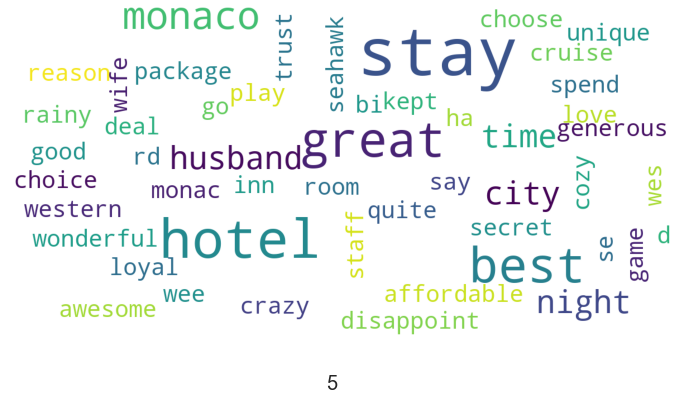

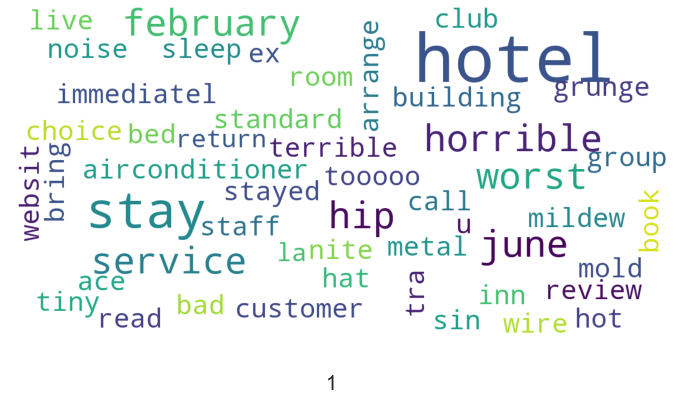

In [18]:
for rating in list(df['Rating'].unique()):
    show_wordcloud(df[df['Rating']==rating]['tokenized'], title=rating)

In [ ]:
# from sklearn.feature_selection import chi2
# import numpy as np
# N = 5
# for Genre, category_id in sorted(category_to_id.items()):
#     print(Genre, category_id)
#     features_chi2 = chi2(train_features, y_train == Genre)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(tfidf_train.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     print("# '{}':".format(Genre))
#     print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#     print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X = df['tokenized']
y = df['Rating']

In [21]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .8, random_state= 42)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

### ASK SEAN do you train test split on the original data or the tokenized data?
* deal with class imbalance in NLP, SMOTE/Tomek Links?

In [23]:
tfidf_train = TfidfVectorizer(sublinear_tf=True, max_df=.8, min_df=10,  ngram_range=(1, 1))

In [24]:
train_features = tfidf_train.fit_transform(X_train).toarray()

In [25]:
test_features = tfidf_train.transform(X_test).toarray()

## Logistic Regression

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

In [27]:
scorer = metrics.make_scorer(metrics.f1_score, average = 'weighted')

In [28]:
nb = MultinomialNB()

In [29]:
params=  {'alpha': [0.09, 0.1,0.11]}

In [30]:
# Instantiate the grid search model
grid_search_nb = GridSearchCV(estimator = nb,scoring=scorer, param_grid = params, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [31]:
grid_search_nb.fit(train_features, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.0min finished


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.09, 0.1, 0.11]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [32]:
print(grid_search_nb.best_params_,
      grid_search_nb.best_score_)

{'alpha': 0.09} 0.5330392597962057


In [33]:
preds_nb = grid_search_nb.best_estimator_.predict(test_features)

In [37]:
preds_nb_train = grid_search_nb.best_estimator_.predict(train_features)

In [38]:
print(metrics.classification_report(y_train,preds_nb_train))

              precision    recall  f1-score   support

           1       0.89      0.80      0.84      1129
           2       0.79      0.62      0.70      1460
           3       0.87      0.26      0.40      1752
           4       0.60      0.56      0.58      4787
           5       0.71      0.91      0.80      7264

    accuracy                           0.71     16392
   macro avg       0.77      0.63      0.67     16392
weighted avg       0.72      0.71      0.69     16392



In [34]:
# Print a classification report
print(metrics.classification_report(y_test,preds_nb))

              precision    recall  f1-score   support

           1       0.76      0.49      0.59       292
           2       0.41      0.37      0.39       333
           3       0.32      0.06      0.10       432
           4       0.47      0.42      0.44      1252
           5       0.65      0.88      0.75      1790

    accuracy                           0.58      4099
   macro avg       0.52      0.44      0.45      4099
weighted avg       0.55      0.58      0.55      4099



## Logistic Regression

In [40]:
from sklearn import linear_model

In [41]:
# Create regularization penalty space
penalty = ['l2']

# Create regularization hyperparameter space
C = np.logspace(0, 1, 10)

# Create hyperparameter options
hyperparameters = dict(C=C)

In [42]:
# Create logistic regression
logistic = linear_model.LogisticRegression(penalty='l2', class_weight='balanced')

In [45]:
# Instantiate the grid search model
grid_search_LR = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = hyperparameters, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [46]:
grid_search_LR.fit(train_features, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 20.6min finished
/Users/ryanlewis/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ])},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [47]:
print(grid_search_LR.best_params_,
      grid_search_LR.best_score_)

{'C': 1.0} 0.5954414006978096


In [48]:
preds_LR_train = grid_search_LR.best_estimator_.predict(train_features)

In [49]:
print(metrics.classification_report(y_train,preds_LR_train))

              precision    recall  f1-score   support

           1       0.86      0.97      0.91      1129
           2       0.78      0.88      0.83      1460
           3       0.63      0.82      0.71      1752
           4       0.69      0.66      0.67      4787
           5       0.86      0.78      0.82      7264

    accuracy                           0.77     16392
   macro avg       0.76      0.82      0.79     16392
weighted avg       0.78      0.77      0.77     16392



In [50]:
preds_LR_test = grid_search_LR.best_estimator_.predict(test_features)

In [52]:
print(metrics.classification_report(y_test,preds_LR_test))

              precision    recall  f1-score   support

           1       0.67      0.69      0.68       292
           2       0.38      0.47      0.42       333
           3       0.35      0.44      0.39       432
           4       0.54      0.47      0.51      1252
           5       0.77      0.75      0.76      1790

    accuracy                           0.61      4099
   macro avg       0.54      0.56      0.55      4099
weighted avg       0.62      0.61      0.61      4099



## Decision Tree

In [55]:
from sklearn import tree 

DT = tree.DecisionTreeClassifier()

In [59]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

parameters = dict(criterion=criterion,
                max_depth=max_depth)

grid_search_DT = GridSearchCV(estimator=DT, param_grid=parameters, scoring=scorer, cv = 5, n_jobs = -1, verbose = 2)


In [60]:
grid_search_DT.fit(train_features, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 12.3min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [61]:
print(grid_search_DT.best_params_,
      grid_search_DT.best_score_)

{'criterion': 'gini', 'max_depth': 10} 0.45058200938993653


In [62]:
preds_DT_train = grid_search_DT.best_estimator_.predict(train_features)

In [63]:
print(metrics.classification_report(y_train,preds_DT_train))

              precision    recall  f1-score   support

           1       0.65      0.42      0.51      1129
           2       0.45      0.30      0.36      1460
           3       0.60      0.22      0.32      1752
           4       0.51      0.47      0.49      4787
           5       0.62      0.82      0.71      7264

    accuracy                           0.58     16392
   macro avg       0.57      0.45      0.48     16392
weighted avg       0.57      0.58      0.56     16392



In [64]:
preds_DT_test = grid_search_DT.best_estimator_.predict(test_features)

In [65]:
print(metrics.classification_report(y_test,preds_DT_test))

              precision    recall  f1-score   support

           1       0.51      0.29      0.37       292
           2       0.24      0.16      0.19       333
           3       0.34      0.11      0.16       432
           4       0.42      0.36      0.39      1252
           5       0.57      0.79      0.67      1790

    accuracy                           0.50      4099
   macro avg       0.41      0.34      0.35      4099
weighted avg       0.47      0.50      0.47      4099



In [1]:
preds_DT_test

NameError: name 'preds_DT_test' is not defined